In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from exp.nb_Tesis import *

In [2]:
# path_train_images = Path('segmented_images/square/ISIC_2019_Training_Input/')
path_train_images = Path('ISIC_2019_Training_Input/')

In [3]:
path_ground_truth = Path('ISIC_2019_Training_GroundTruth.csv')
# path_test_images = Path('segmented_images/square/ISIC2018_Task3_Test_Input/')
path_test_images = Path('ISIC2018_Task3_Test_Input/')

In [4]:
df = pd.read_csv(path_ground_truth); print(f'{len(df)} images: ')

dfSingleLabel = pd.DataFrame({'image':df['image'] })
labelcols = df.columns[1:len(df.columns)]
dfSingleLabel['label'] = df[list(labelcols)].idxmax(axis='columns')
dfSingleLabel.sample(25331,replace=True)

25331 images: 


,image,label
1475,ISIC_0012671_downsampled,NV
24502,ISIC_0071957,MEL
11643,ISIC_0033046,NV
4476,ISIC_0025879,BKL
2194,ISIC_0014328_downsampled,NV
...,...,...
19988,ISIC_0064803,MEL
6155,ISIC_0027558,NV
9383,ISIC_0030786,NV
7508,ISIC_0028911,NV


In [5]:
dfSingleLabel.groupby('label').count()

,image
label,
AK,867
BCC,3323
BKL,2624
DF,239
MEL,4522
NV,12875
SCC,628
VASC,253


In [6]:
labels_for_2018_live_challenge = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']
def get_label_for_image_name(image_name):
  return list(dfSingleLabel.loc[dfSingleLabel['image']==image_name].label)[0]
def get_label_for_image_path(image_path): return get_label_for_image_name(image_path.name[:-4])

In [7]:
n_of_images_to_keep_per_class = 700
path_reduced_ds =  (path_train_images / f'reduced-{n_of_images_to_keep_per_class}')
path_reduced_ds.mkdir(exist_ok=True)
path_reduced_ds

PosixPath('ISIC_2019_Training_Input/reduced-700')

In [8]:
# for idx, label in enumerate(labels_for_2018_live_challenge):
#     print(label)
#     current_label_df_entries = dfSingleLabel.loc[dfSingleLabel['label']==label]
#     n_rows_per_class = len(current_label_df_entries)
#     n_to_sample = min(n_of_images_to_keep_per_class, n_rows_per_class)
    
#     for idx1,row in enumerate(current_label_df_entries.sample(n_to_sample).itertuples()):
#         path_img_orig = path_train_images / (row.image + '.jpg')
#         update_progress(idx1 / n_to_sample)
#         !cp $path_img_orig $path_reduced_ds
        

In [9]:
path_segmented_ds = path_reduced_ds / 'segmented_images_as_284'

In [10]:
assert len(get_image_files(path_segmented_ds)) == 3992
# len(get_image_files(path_reduced_ds)) 

In [11]:
def random_seed(seed_value, use_cuda):  #gleaned from multiple forum posts
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: torch.cuda.manual_seed_all(seed_value) # gpu 

In [12]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [22]:
random_seed(7,True)
tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=.5, max_lighting=.3,p_affine=1)
#Descomentar para correccion de color
# tfms[0].append(correct_color())
# tfms[1].append(correct_color())

data = ImageList.from_folder(path_segmented_ds,recurse=False)\
.split_by_rand_pct()\
.label_from_func(get_label_for_image_path)\
.transform(tfms)\
.databunch(bs=32)\
.normalize()

In [23]:
data

ImageDataBunch;

Train: LabelList (3194 items)
x: ImageList
Image (3, 284, 284),Image (3, 284, 284),Image (3, 284, 284),Image (3, 284, 284),Image (3, 284, 284)
y: CategoryList
MEL,BKL,BKL,NV,BCC
Path: ISIC_2019_Training_Input/reduced-700/segmented_images_as_284;

Valid: LabelList (798 items)
x: ImageList
Image (3, 284, 284),Image (3, 284, 284),Image (3, 284, 284),Image (3, 284, 284),Image (3, 284, 284)
y: CategoryList
AK,MEL,AK,MEL,AK
Path: ISIC_2019_Training_Input/reduced-700/segmented_images_as_284;

Test: None

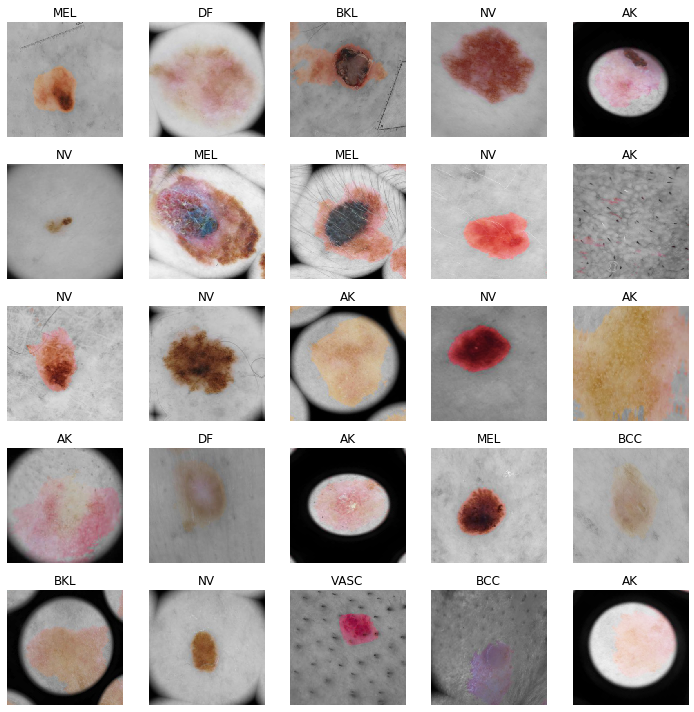

In [24]:
data.show_batch(rows=5, figsize=(10,10))

In [25]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

In [26]:
print(train_count,'\n\n',valid_count)

BCC     572
BKL     561
NV      559
MEL     556
AK      554
DF      196
VASC    196
dtype: int64 

 AK      146
MEL     144
NV      141
BKL     139
BCC     128
VASC     57
DF       43
dtype: int64


In [27]:
# del learn?
# del data

torch.cuda.empty_cache()
gc.collect()

45280

In [28]:
!nvidia-smi

Tue Nov 26 18:16:33 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   50C    P2    62W / 250W |   2010MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:09:00.0 Off |                  N/A |
|  0%   31C    P2    58W / 250W |    607MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [29]:
random_seed(7,True)
# x50 = lambda x: xresnet50()
learn = cnn_learner(data,models.resnet101, 
                    metrics=[error_rate,accuracy],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ], 
                    
                    pretrained=True
                    )

In [30]:
learn.model = nn.DataParallel(learn.model)

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


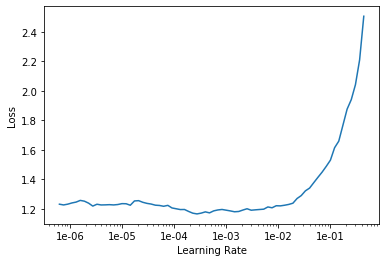

In [33]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.351353,1.821943,0.553885,0.446115,00:48
1,1.787712,1.275944,0.452381,0.547619,00:43
2,1.459708,1.182086,0.446115,0.553885,00:42
3,1.264578,1.114296,0.409774,0.590226,00:43


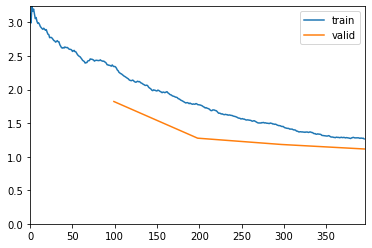

Better model found at epoch 0 with valid_loss value: 1.8219425678253174.
Better model found at epoch 1 with valid_loss value: 1.2759442329406738.
Better model found at epoch 2 with valid_loss value: 1.1820862293243408.
Better model found at epoch 3 with valid_loss value: 1.1142960786819458.


In [31]:
learn.fit_one_cycle(4, callbacks = [
    SaveModelCallback(learn=learn),
    ReduceLROnPlateauCallback(learn=learn)
])

In [34]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.535462,2.147224,0.614035,0.385965,00:52


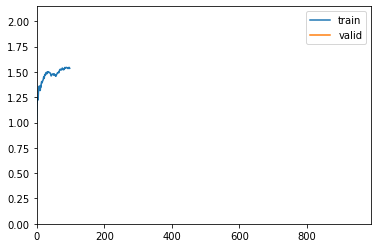

Better model found at epoch 0 with valid_loss value: 2.147224187850952.


Exception in thread Thread-1467:
Traceback (most recent call last):
  File "/home/mike/miniconda3/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/mike/miniconda3/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mike/miniconda3/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/mike/miniconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 294, in rebuild_storage_fd
    fd = df.detach()
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 87

KeyboardInterrupt: 

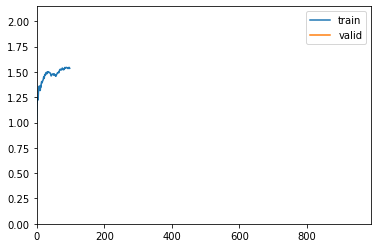

In [35]:
random_seed(7,True)
learn.fit_one_cycle(10, wd=1e-06, max_lr=slice(1e-03,1e-02),callbacks = [
    SaveModelCallback(learn=learn),
    ReduceLROnPlateauCallback(learn=learn)
])

In [107]:
learn.export('square_classifier_seg.pkl')

/home/mike/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mike/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DataParallel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mike/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mike/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__na

## Interpretation

In [108]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(30, figsize=(12,12),heatmap=True)


interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

AssertionError: `heatmap=True` requires a model like `cnn_learner` produces.

## test

In [64]:
learn.export('square_classifier.pkl')

In [111]:
data_test = ImageList.from_folder(path_test_images/'segmented_images');

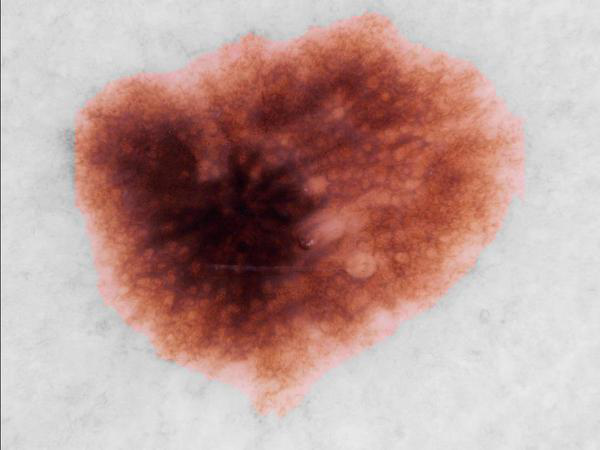

In [112]:
data_test[6]

In [114]:
learn_inference = load_learner(path_segmented_ds, test=data_test, file='square_classifier_seg.pkl')

In [115]:
learn_inference.data.item

In [76]:
preds, y = learn_inference.TTA(ds_type=DatasetType.Test, beta=0.4, scale=1.35)

In [ ]:
preds, y = learn_inference.get_preds(ds_type=DatasetType.Test)

In [ ]:
assert len(preds) == 1512

In [ ]:
preds[0]

In [ ]:
arrOfPreds = [learn_inference.data.classes[pred.argmax().item()] for pred in preds];arrOfPreds[0:5]

Generamos primero el dataframe con las predicciones

In [ ]:

allCategories = learn_inference.data.classes
cols = ['image'] + allCategories


predictions = []
for idx, filePath in enumerate(learn_inference.data.test_ds.items):
  row = {}
  current_pred = preds[idx]
  max_confidence = current_pred.max().item()
  row['image'] = filePath.name.replace('.jpg','')
  for idx2, cat in enumerate(allCategories):
    row[cat] = current_pred[idx2].item()
  
  predictions.append(row)

predictionsDf = pd.DataFrame(predictions, columns=cols);
  
  

In [ ]:
len(predictionsDf)
predictionsDf = predictionsDf.rename(columns={'AK':'AKIEC'})
predictionsDf.head()

In [ ]:
predictions_csv_path = 'revancha2.csv'
# true_labels_csv_path = currentDatasetPath/'trueLabels.csv'



predictionsDf.to_csv(predictions_csv_path, index=False)
# trueLabelsDf.to_csv(true_labels_csv_path,index=False)

